## 3. InvestigateChi-Square

In this notebook, we dive into the issue with the bad chi-squres (>100). We show that this population existance is due to the lack of model coverage for the LSST colors. Our main takeaways of this analysis are the following:
- The feature seen on cosmoDC2 is mainly due because of our library model doesn't use LSST filters. Since the DES and LSST filters are slightly different they have different color evolution shapes.
- This weird population have chisqr > 100, our BMA model fails to assign a model probability in this regime, basically all the models are zero.

###  Dataset

We use the otuput from the algoritgm BMA Stellar Mass (Palmese et al. 2019)

In [5]:
import numpy as np
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

# 'font.sans-serif': ['Arial',
#   'DejaVu Sans',
#   'Liberation Sans',
#   'Bitstream Vera Sans',
#   'sans-serif'],

In [6]:
root = '/home/s1/jesteves/git/bmaCosmoDC2/'

In [7]:
galc= Table(getdata('/data/des61.a/data/johnny/CosmoDC2/runBMACosmoDC2/data/cosmoDC2_bma_cluster_galaxies.fits'))
galf= Table(getdata('/data/des61.a/data/johnny/CosmoDC2/runBMACosmoDC2/data/cosmoDC2_bma_field_galaxies.fits'))

galc['field'] = False
galf['field']= True

g0 = vstack([galc,galf])
g0['jid'] = np.arange(len(g0))

In [8]:
rsflag = Table(getdata('/data/des61.a/data/johnny/CosmoDC2/runBMACosmoDC2/data/matched_table.fits'))

In [9]:
rsflag

<Table length=134667>
Mag_true_g_lsst_z0 Mag_true_i_lsst_z0 ...         decn         jid  
     float32            float32       ...       float64       int64 
------------------ ------------------ ... ------------------- ------
        -22.351065         -23.525345 ...  -25.77676365581047      0
        -20.546082         -21.717037 ...  -25.77128074426682      1
        -21.037712         -22.092745 ...  -25.76577503948369      2
         -21.87688          -22.94467 ... -25.755437627182314      3
        -21.230402          -22.33154 ...  -25.75404026642085      4
         -19.91071         -21.083872 ...  -25.79966249743572      5
        -21.906183         -22.950886 ... -25.717999338060135      6
        -20.489262         -21.629698 ... -25.720104401283024      7
        -22.930986         -24.089695 ... -24.858377701311454      8
        -20.559685          -21.65406 ...  -24.85725001122821      9
               ...                ... ...                 ...    ...
        -20.324404         -21.401903 ... -45.911075190260185 134658
        -20.914309         -21.925814 ... -46.271916008160346 134659
        -20.424707          -21.22597 ...  -46.09084102729878 134660
        -19.936993         -20.926994 ... -46.298855364866895 134661
        -20.074043         -20.883501 ...  -45.92148478208889 134662
        -20.620121         -21.692013 ... -46.351945460519225 134663
        -20.264717         -20.796911 ...  -45.93539438446411 134664
         -21.01925         -21.815773 ...   -46.2782555741167 134665
        -20.617554         -21.185986 ...  -46.09205141494084 134666
        -20.135162         -21.244396 ...  -46.21733904594248 134667

In [10]:
rsflag.remove_columns('stellar_mass')
rsflag.remove_columns('redshift')

In [11]:
gal_all = join(g0,rsflag,keys=['jid'])

In [12]:
gal_all.columns

<TableColumns names=('magerr','magLim','dmag','CID','redshift','mid','R','RA','mag','Mr','z_true','DEC','True','stellar_mass','Pr','Pz','pdfc','pdfm_bkg','zerr','pdfz','Pc','pdfr','Rn','zoffset','pdfm','pdfc_bkg','pdfr_bkg','norm','Pmem','pdf_bkg','Ptaken','pz0','GID_1','pdfz_bkg','pdf','z','mass_weight_age_err','gi_o','index','rabs','gr_o_err','gi_o_err','kri','zmet','best_chisq','mass_err','kii_err','kri_err','ssfr_std','kii','best_model','distmod','best_zmet','mcMass','iobs','taMass','mass_weight_age','iabs','mass','gr_o','ssfr','field','jid','Mag_true_g_lsst_z0','Mag_true_i_lsst_z0','Mag_true_r_sdss_z0','mag_r_sdss','mag_i_sdss','baseDC2/is_on_red_sequence_ri','photoz_mask','galaxy_id','mag_true_i_lsst','mag_true_i_sdss','ra','mag_true_g_lsst','is_central','mag_true_r_lsst','baseDC2/is_on_red_sequence_gr','dec','mag_true_r_sdss','Mag_true_i_sdss_z0','Mag_true_r_lsst_z0','GID_2','ran','decn')>

In [13]:
field = gal_all['field'] 
nfield= np.logical_not(field)

gal = gal_all[nfield]
galb= gal_all[field]

###  Stellar Mass Validation

In this section we measure the stellar mass accuracy of BMA Stellar Mass.

In [14]:
rs_flag = gal['baseDC2/is_on_red_sequence_ri']
rs_flagb= galb['baseDC2/is_on_red_sequence_ri']

nrs_flag = np.logical_not(rs_flag)
nrs_flagb= np.logical_not(rs_flagb)

In [15]:
def get_residual_variables(data,kind,cut=[None,None]):
    zcls = data['z_true']
    if kind=='mass':
        toto = (data['stellar_mass']/10**data['mass'])
        res  = np.log10(toto)
        xvar = data['stellar_mass']
    else:
        res  = data['rabs']-data['Mr']
        xvar = data['Mr']
    xvar = data['stellar_mass']
    mask = np.logical_not(np.isnan(res))
    if cut[0] is not None:
        mask &= data[cut[0]] >= cut[1]
        
    return zcls[mask],res[mask], xvar[mask]

def evolution(data,col,ax=None,s=5,alpha=0.1,title=''):
    if ax is None: ax=plt.axes()
    x = data['z_true']
    y = data[col]
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)
    
def residual_evolution(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',label=True):
    if ax is None: ax=plt.axes()
    z,residual,_ = get_residual_variables(data,kind,cut=cut)
    ax.scatter(z,residual,s=s,alpha=alpha)
    if label: ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)

def residual_logmas(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',density=False,log=True,color='b'):
    if ax is None: ax=plt.axes()
    zcls,residual,xvar = get_residual_variables(data,kind,cut=cut)
    if density:
        idx = np.argsort(-1*zcls)[::1]
        im = ax.scatter(xvar[idx],residual[idx],s=s,alpha=alpha,c=zcls[idx],cmap='Paired')
        fig.colorbar(im,ax=ax)
    else:
        ax.scatter(xvar,residual,s=s,alpha=alpha)
    ax.set_xlabel(r'Log($M_{\star}^{DC2}/ M_{\odot}$)')
    ax.set_title(title)
    if log: ax.set_xscale('log')

In [16]:
mass_label = r'Log $\left(M_{\star}^{DC2} / M_{\star}^{BMA} \right)$'
mr_label   = r'$M_r^{BMA}-M_r^{DC2}$'
residual_labels = [mass_label,mr_label]

Text(0,0.5,'$M_{\\star}^{DC2}$')

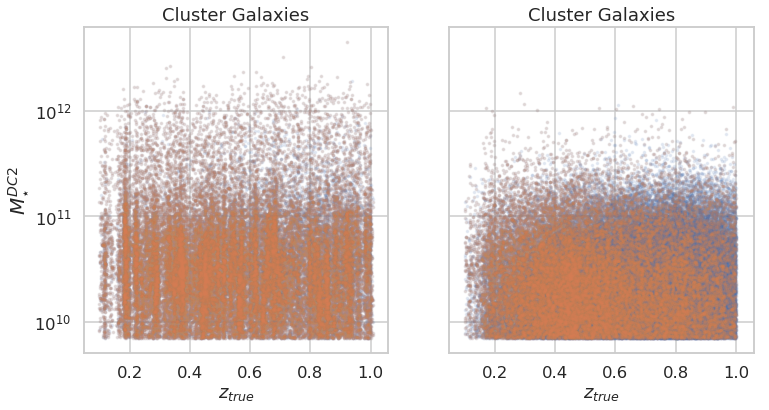

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
evolution(gal ,'stellar_mass',ax=axis[0],title='Cluster Galaxies')
evolution(gal[rs_flag] ,'stellar_mass',ax=axis[0],title='Cluster Galaxies')

evolution(galb,'stellar_mass',ax=axis[1],title='Field   Galaxies')
evolution(galb[rs_flagb] ,'stellar_mass',ax=axis[1],title='Cluster Galaxies')

axis[0].set_yscale('log')
axis[0].set_ylabel(r'$M_{\star}^{DC2}$',fontsize=20)
# axis[0].set_xscale('log')
#axis[0].set_ylim(1,-1.)

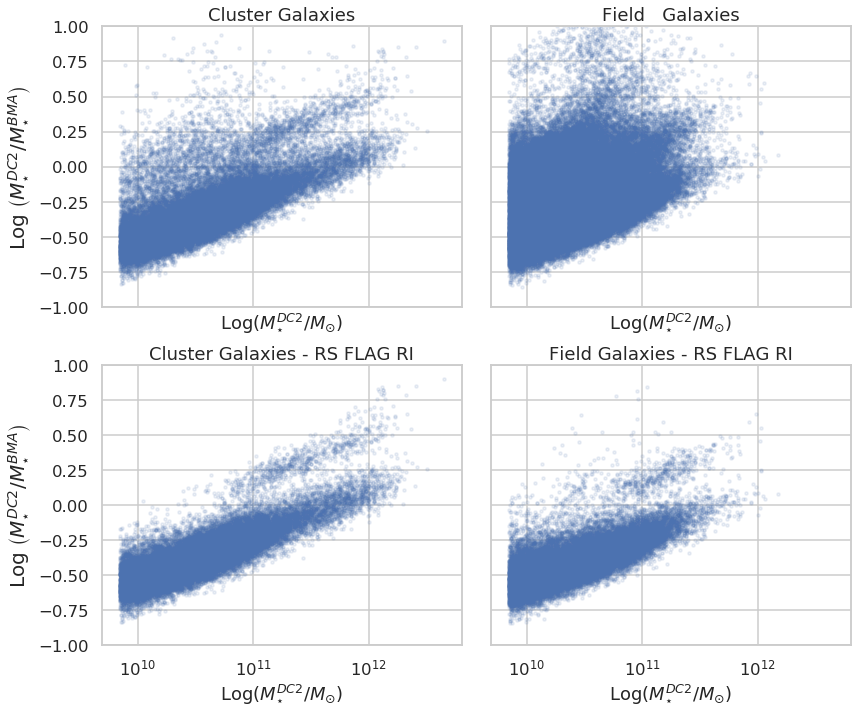

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(12,10), sharex='all',sharey='all')
residual_logmas(gal ,'mass',alpha=0.1,s=10,ax=axis[0,0],title='Cluster Galaxies')
residual_logmas(gal[rs_flag] ,'mass',alpha=0.1,s=10,ax=axis[1,0],title='Cluster Galaxies - RS FLAG RI')

residual_logmas(galb,'mass',alpha=0.1,s=10,ax=axis[0,1],title='Field   Galaxies')
residual_logmas(galb[rs_flagb],'mass',alpha=0.1,s=10,ax=axis[1,1],title='Field Galaxies - RS FLAG RI')

axis[0,0].set_ylabel(residual_labels[0],fontsize=20)
axis[1,0].set_ylabel(residual_labels[0],fontsize=20)
# axis[0,0].set_xscale('log')
axis[0,0].set_ylim(-1,1.)
fig.tight_layout()

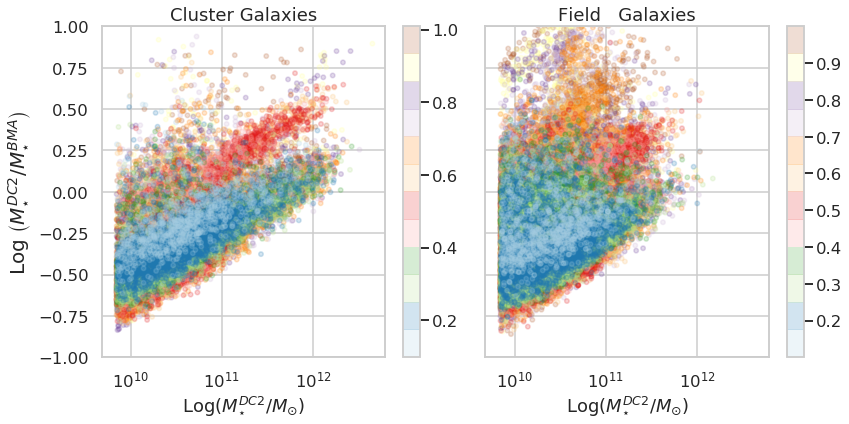

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_logmas(gal ,'mass',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies',density=True)
residual_logmas(galb,'mass',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies',density=True)
axis[0].set_ylabel(residual_labels[0],fontsize=20)
# axis[0].set_xscale('log')
axis[0].set_ylim(-1,1.)
fig.tight_layout()
plt.savefig('../graphs/mass_residual_logmass.png')

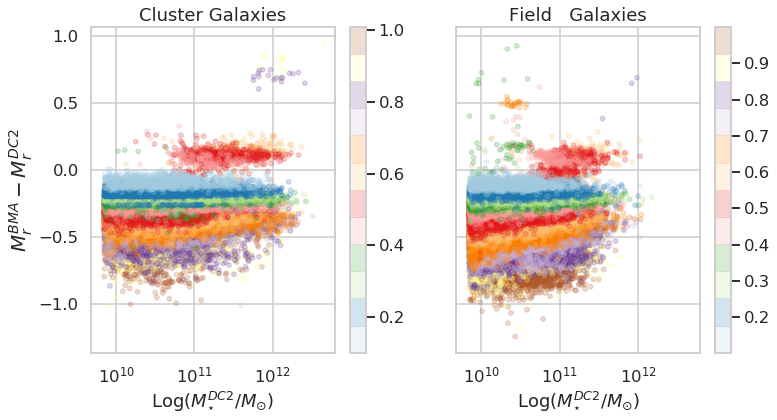

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_logmas(gal ,'Mr',alpha=0.2,s=20,ax=axis[0],title='Cluster Galaxies',density=True,log=True)
residual_logmas(galb,'Mr',alpha=0.2,s=20,ax=axis[1],title='Field   Galaxies',density=True,log=True)
axis[0].set_ylabel(residual_labels[1],fontsize=20)
# axis[0].set_xscale('log')
# axis[0].set_ylim(1,-1.)
plt.savefig('../graphs/Mr_residual_logmass.png')

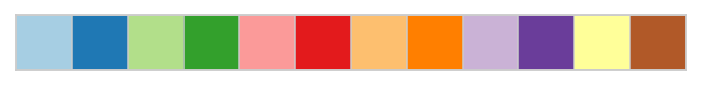

In [19]:
sns.palplot(sns.color_palette("Paired"))

In [17]:
colorGradient = sns.color_palette("Paired")[:]

In [18]:
kii = -gal['mag'][:,2]+gal['Mag_true_i_lsst_z0']+gal['distmod']

In [19]:
kmask  = gal['kii']==0
kmaskb = galb['kii']==0

nkmask = np.logical_not(kmask)
nkmaskb= np.logical_not(kmaskb)

Text(0.5,0,'$z_{true}$')

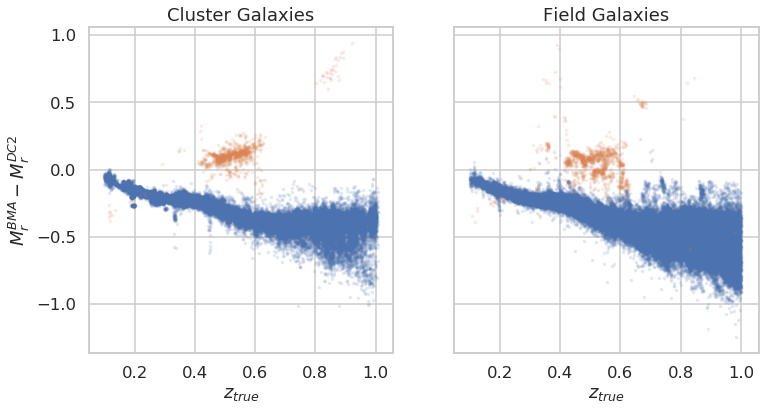

In [20]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

residual_evolution(gal[nkmask] ,'Mr',ax=axis[0],title='Cluster Galaxies')
residual_evolution(gal[kmask] ,'Mr',ax=axis[0],title='Cluster Galaxies')

residual_evolution(galb[nkmaskb] ,'Mr',ax=axis[1],title='Field Galaxies')
residual_evolution(galb[kmaskb] ,'Mr',ax=axis[1],title='Field Galaxies')

axis[0].set_ylabel(r'$M_r^{BMA}-M_r^{DC2}$')
plt.xlabel(r'$z_{true}$')

#residual_evolution(galb,'Mr',ax=axis[1])
# axis[0].set_ylim(1,-1.)

Text(0,0.5,'k-corr: kii')

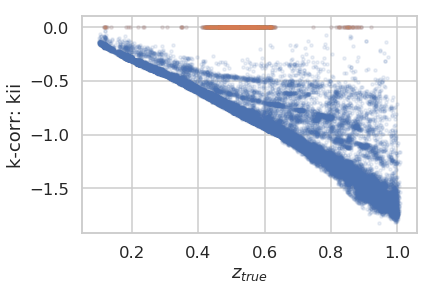

In [24]:
plt.scatter(gal['z_true'],gal['kii'],s=10,alpha=0.1)
plt.scatter(gal['z_true'][kmask],gal['kii'][kmask],s=10,alpha=0.1)
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'k-corr: kii')

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'$z_{true}$')

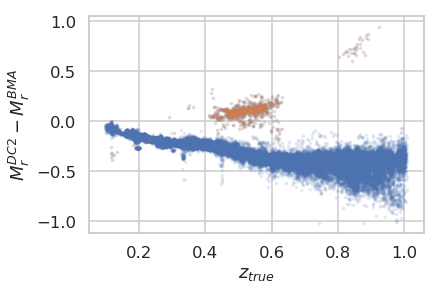

In [25]:
residual_evolution(gal ,'Mr')
residual_evolution(gal[kmask] ,'Mr')
plt.ylabel(r'$M_r^{DC2}-M_r^{BMA}$')
plt.xlabel(r'$z_{true}$')

Text(0.5,0,'Models')

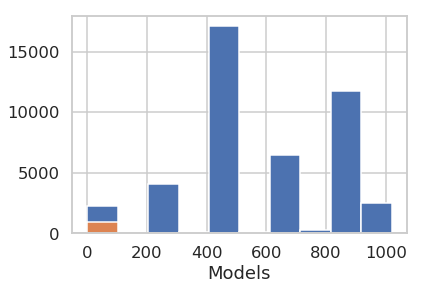

In [26]:
a = plt.hist(gal['best_model'])
_ = plt.hist(gal['best_model'][kmask],bins=a[1])
plt.xlabel('Models')

In [27]:
z = gal['z_true']

In [28]:
gal['gi_o_true'] = gal['Mag_true_g_lsst_z0']-gal['Mag_true_i_lsst_z0']
gal['gr_o_true'] = gal['Mag_true_g_lsst_z0']-gal['Mag_true_r_lsst_z0']

Text(0.5,0,'$(g-r)_{0,BMA}-(g-r)_{0,DC2}$')

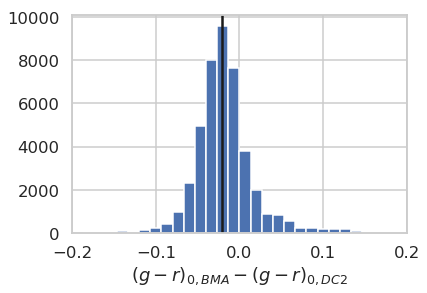

In [29]:
_ = plt.hist(gal['gr_o']-gal['gr_o_true'],bins=np.linspace(-0.2,0.2,31))
plt.axvline(-0.021,color='k')
plt.xlim(-0.2,0.2)
plt.xlabel('$(g-r)_{0,BMA}-(g-r)_{0,DC2}$')

(-0.1, 0.1)

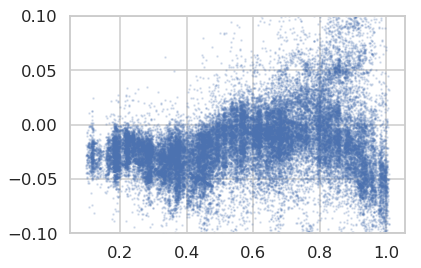

In [30]:
plt.scatter(z,gal['gr_o']-gal['gr_o_true'],s=1,alpha=0.2)
plt.ylim(-0.1,0.1)

In [31]:
mag    = gal['mag']
magerr = gal['magerr']

Text(0.5,0,'$mag$')

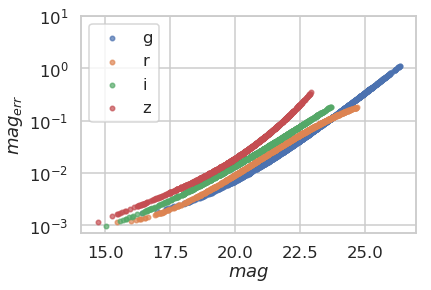

In [32]:
labels = ['g','r','i','z']
for i in range(4):
    plt.scatter(mag[::50,i],magerr[::50,i],s=20,alpha=0.7,label=labels[i])

plt.legend()
plt.yscale('log')
plt.ylim(0.0007,10)
plt.ylabel('$mag_{err}$')
plt.xlabel(r'$mag$')


Text(0.5,1,'$(g-r)_{0,DC2}$')

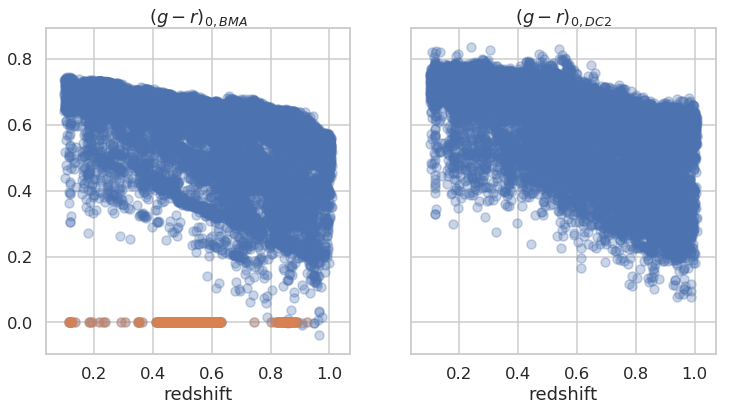

In [33]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
axis[0].scatter(z,gal['gr_o'],alpha=0.3)
axis[0].scatter(z[kmask],gal['gr_o'][kmask],alpha=0.3)

axis[1].scatter(z,gal['gr_o_true'],alpha=0.3)

axis[0].set_xlabel('redshift')
axis[1].set_xlabel('redshift')

axis[0].set_title('$(g-r)_{0,BMA}$')
axis[1].set_title('$(g-r)_{0,DC2}$')
#axis[1].scatter(z[rs_flag],gal['gi_o_true'][rs_flag],alpha=0.1)

Text(0.5,0,'redshift')

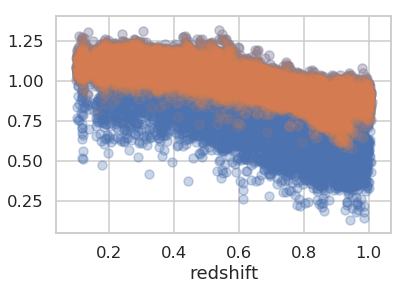

In [34]:
plt.scatter(z,gal['gi_o_true'],alpha=0.3)
plt.scatter(z[rs_flag],gal['gi_o_true'][rs_flag],alpha=0.1)
plt.xlabel('redshift')
#plt.scatter(z[kmask],gal['gi_o_true'][kmask],alpha=0.3)

In [35]:
grerr = np.log10(np.sqrt(gal['magerr'][:,1]**2+gal['magerr'][:,2]**2))

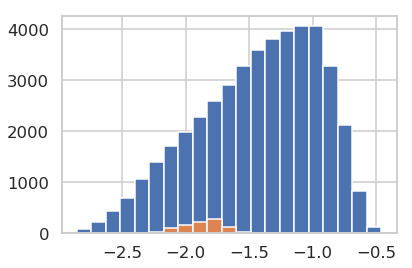

In [36]:
a = plt.hist(grerr,bins=21)
_ = plt.hist(grerr[kmask],bins=a[1])

Text(0.5,0,'redshift')

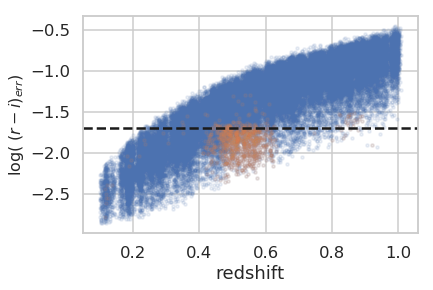

In [37]:
plt.scatter(z,grerr,s=10,alpha=0.1)
plt.scatter(z[kmask],grerr[kmask],s=10,alpha=0.1)
plt.axhline(np.log10(0.02),color='k',ls='--')
plt.ylabel('log( ($r-i)_{err}$)',fontsize=16)
plt.xlabel('redshift')

In [38]:
gr = gal['mag'][:,1]-gal['mag'][:,2]

Text(0,0.5,'$r-i$')

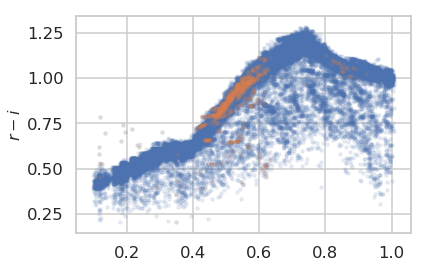

In [39]:
plt.scatter(z,gr,s=10,alpha=0.1)
plt.scatter(z[kmask],gr[kmask],s=10,alpha=0.1)
plt.ylabel('$r-i$',fontsize=16)

### Stellar Mass Library 

In [21]:
import sys
sys.path.append('/home/s1/jesteves/git/ccopa/python/bma')

import loadPopColors
libPath= '/data/des61.a/data/pbarchi/galaxyClusters/simha_miles_Nov2016/'
splines, zmet = loadPopColors.doAll(libPath, lib="miles")

In [22]:
def _get_spline(spline,zmet,zed):
    # for speed
    sgr  = float(spline[0](zed))
    sri  = float(spline[1](zed))
    siz  = float(spline[2](zed))
    sgrr = float(spline[4](zed)) ;# restframe g-r
    sgir = float(spline[5](zed)) ;# restframe g-i
    skii = float(spline[6](zed)) ;# kcorrection: i_o - i_obs
    skri = float(spline[7](zed)) ;# kcorrection: r_o - i_obs
    sml  = float(spline[8](zed)) ;# log(mass/light)  (M_sun/L_sun)
    ssfr = float(spline[9](zed))
    if (ssfr<-20.): ssfr=-20.
    sage_cosmic = float(spline[10](zed))
    sage = float(spline[11](zed))
    szmet = float(zmet)
    return np.array([sgr,sri,siz,sgrr,sgir,skii,skri,sml,ssfr,sage,szmet])

def get_spline(spline,zmet,allzed):
    unique_zed, index_zed = np.unique(allzed,return_inverse=True)
    nsize = unique_zed.size
    toto = np.zeros((nsize,11),dtype=np.float64)

    for i,zed in enumerate(unique_zed):
        toto[i] = _get_spline(spline,zmet,zed)
    
    cols  = ['sgr','sri','siz','sgrr','sgir','skii','skri','sml','ssfr','sage','szmet']
    res   = dict().fromkeys(cols)
    for i,col in enumerate(cols):
        arr = np.array(toto[:,i])
        res[col] = arr[index_zed]
    return res

In [23]:
dz   = 0.01
zvec = np.arange(0.1,1.+dz,dz)

In [24]:
spline_list_Dict = [get_spline(splines[sp],zmet[sp],zvec) for sp in range(len(splines))]

In [25]:
def calculcate_color_column(data):
    labels = ['gr','ri','iz']
    for i in range(3):
        data[labels[i]] = data['mag'][:,i]-data['mag'][:,i+1]
        data[labels[i]+'_err'] = np.sqrt(data['magerr'][:,i]**2+data['magerr'][:,i+1]**2)
    return data

In [26]:
gal = calculcate_color_column(gal)
galb= calculcate_color_column(galb)

In [27]:
## DES Y3 redMaPPer
redSequence_file = '/home/s1/jesteves/backup/Memb-assign/aux-table/redSequence_Fit_redmapper_z_binned_Pmem_cut.txt'
rs = np.genfromtxt(redSequence_file)

# z,gr_mean,gr_0,gr_slope, ri_mean, ri_0, ri_slope, iz_mean, ...

#### Color Distribution

In [28]:
def color_evolution(data,lcol,s=10,alpha=0.1,ax=None,title=''):
    if ax is None: ax = plt.axes()
    color = data[lcol]
    zcls  = data['z_true'][:]
    ax.scatter(zcls,color,s=s,alpha=alpha,label='_')
    ax.set_title(title)
    ax.set_xlabel(r'$z_{true}$')

def color_mag(data,lcol,ix=1,s=30,alpha=0.3,ax=None,title='',zlims=[0.,1]):
    zl,zh = zlims
    mag   = data['mag'][:,ix]
    color = data[lcol]
    zcls  = data['z_true'][:]
    mask  = (zcls<=zh)&(zcls>=zl)
    ax.scatter(mag[mask],color[mask],s=s,alpha=alpha,label='_')
    ax.set_title(title)


In [29]:
ml,mh = 10**9.7, 10**10.8
mask1 = (gal['stellar_mass']>=ml)&(gal['stellar_mass']<=mh)
mask2 = (gal['stellar_mass']>=mh)

mask1b= (galb['stellar_mass']>=ml)&(galb['stellar_mass']<=mh)
mask2b= (galb['stellar_mass']>=mh)

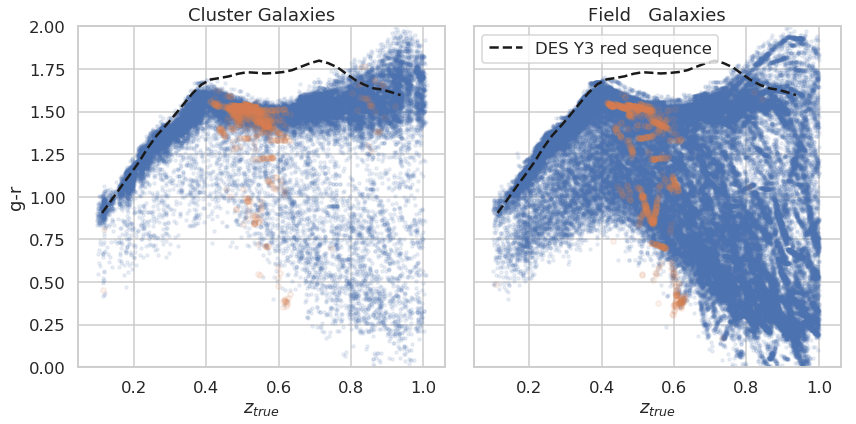

In [49]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask1&(nkmask)],'gr',ax=axis[0])
color_evolution(gal[mask2&(kmask )],'gr',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,1],'k--')

color_evolution(galb[mask1b&(nkmaskb)],'gr',ax=axis[1])
color_evolution(galb[mask2b&(kmaskb)],'gr',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,1],'k--',label='DES Y3 red sequence')

axis[0].set_ylabel('g-r')
axis[0].set_ylim(0.,2.)
axis[1].legend()
fig.tight_layout()

In [33]:
zmax,zmin = 1.,0.1
w, = np.where((zvec<=zmax)&(zvec>=zmin))

mydict = {'gr':0+1,'ri':4,'iz':7}
def plot_color_evolution(ax,ci,ylims=[0.,1.],models=False):
    if models:
        for i in range(len(splines))[::3]:
            ax.plot(zvec[w],spline_list_Dict[i]['s%s'%ci][w],alpha=0.2,label='_')
    
        ax.plot(zvec[w],spline_list_Dict[i+1]['s%s'%ci][w],alpha=0.2,label='FSPS models')
    
    ax.scatter(gal['z_true'][::5],gal[ci][::5],s=10,alpha=0.2,zorder=-1,label='_')
    ax.scatter(gal['z_true'][mask2&kmask],gal[ci][mask2&kmask],s=10,alpha=0.2,zorder=-1,label='_')
    #ax.scatter(gal['zmet'],out_data[ci],color='k',s=10,alpha=0.1,zorder=100)
    ax.plot(rs[:,0],rs[:,mydict[ci]],'k--',label='DES Y3 red sequence')
    
    ax.set_title(ci)
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel('$z_{true}$')

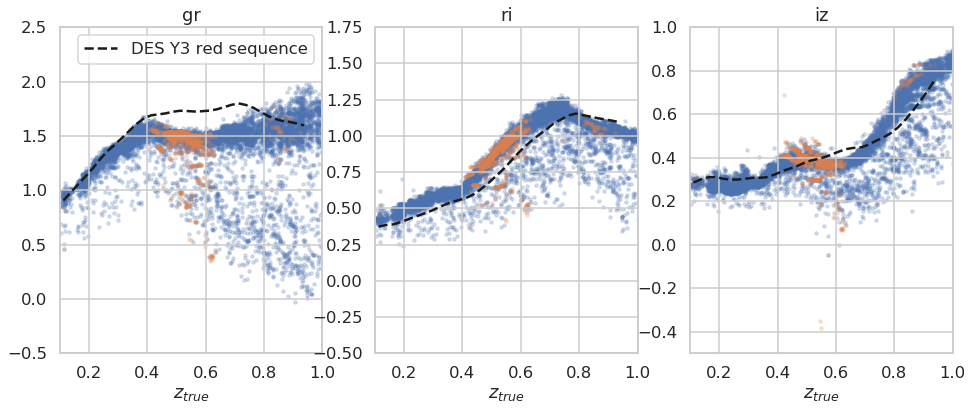

In [34]:
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex='all')

plot_color_evolution(axis[0],'gr',ylims=[-.5,2.5])
plot_color_evolution(axis[1],'ri',ylims=[-.5,1.75])
plot_color_evolution(axis[2],'iz',ylims=[-.5,1.])
axis[0].set_xlim(zmin,zmax)
axis[0].legend()

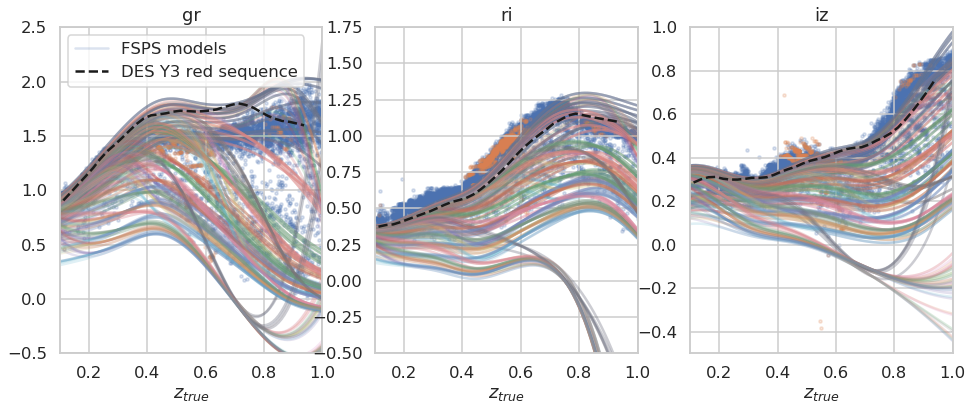

In [135]:
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex='all')

plot_color_evolution(axis[0],'gr',ylims=[-.5,2.5],models=True)
plot_color_evolution(axis[1],'ri',ylims=[-.5,1.75],models=True)
plot_color_evolution(axis[2],'iz',ylims=[-.5,1.],models=True)
axis[0].set_xlim(zmin,zmax)
axis[0].legend()

In [2]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")

from main import copacabana
cfg = '/home/s1/jesteves/git/ccopa/config_files/config_buzzard_v2.yaml'
copa = copacabana(cfg,dataset='buzzard_v2')

buz = copa.load_copa_out('members','g001-rhod')

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00001.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00002.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00003.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles
Matching Copa output with main and BMA
Matching Copa output with main and BMA
Matching Copa output with main and BMA


In [30]:
buz = calculcate_color_column(buz)

In [38]:
def plot_color_evolution(ax,ci,ylims=[0.,1.],models=False):
    if models:
        for i in range(len(splines))[::3]:
            ax.plot(zvec[w],spline_list_Dict[i]['s%s'%ci][w],alpha=0.2,label='_')
    
        ax.plot(zvec[w],spline_list_Dict[i+1]['s%s'%ci][w],alpha=0.2,label='FSPS models')
    
    #ax.scatter(gal['z_true'][::5],gal[ci][::5],s=10,alpha=0.2,zorder=-1,label='_')
    ax.scatter(buz['z_true'],buz[ci],s=10,alpha=0.2,zorder=-1,label='_')
    #ax.scatter(gal['z_true'][mask2&kmask],gal[ci][mask2&kmask],s=10,alpha=0.2,zorder=-1,label='_')
    #ax.scatter(gal['zmet'],out_data[ci],color='k',s=10,alpha=0.1,zorder=100)
    ax.plot(rs[:,0],rs[:,mydict[ci]],'k--',label='DES Y3 red sequence')
    
    ax.set_title(ci)
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel('$z_{true}$')

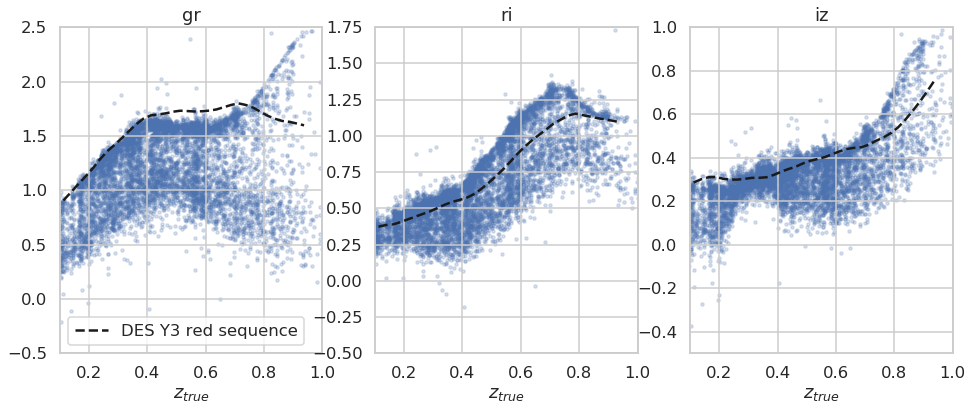

In [39]:
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex='all')

plot_color_evolution(axis[0],'gr',ylims=[-.5,2.5],models=False)
plot_color_evolution(axis[1],'ri',ylims=[-.5,1.75],models=False)
plot_color_evolution(axis[2],'iz',ylims=[-.5,1.],models=False)
axis[0].set_xlim(zmin,zmax)
axis[0].legend()

Text(0.5,0.98,'Buzzard v2.0')

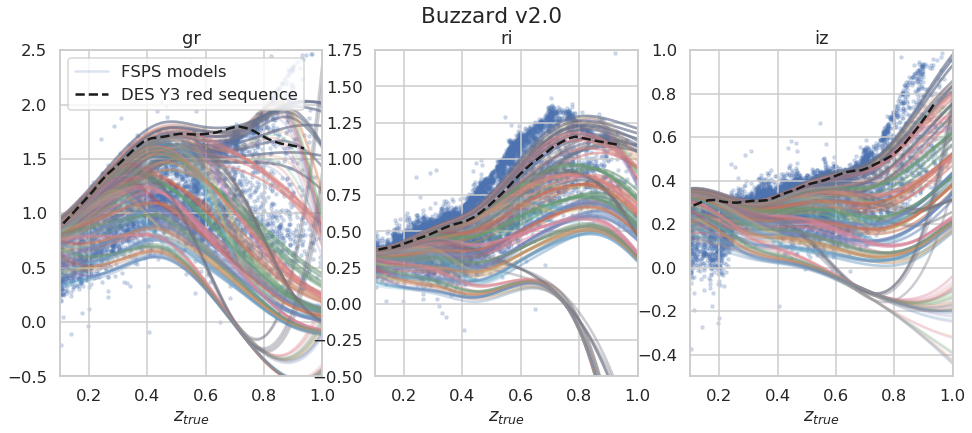

In [41]:
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex='all')

plot_color_evolution(axis[0],'gr',ylims=[-.5,2.5],models=True)
plot_color_evolution(axis[1],'ri',ylims=[-.5,1.75],models=True)
plot_color_evolution(axis[2],'iz',ylims=[-.5,1.],models=True)
axis[0].set_xlim(zmin,zmax)
axis[0].legend()
fig.suptitle('Buzzard v2.0')

In [143]:
def get_floor(x):
    ix = np.where(x<0.02)[0]
    x[ix] = 0.02
    return x
def get_color_difference(splines_dict,data):
    dgr,dri,diz = [],[],[]
    gr,grerr = data['gr'],get_floor(data['gr_err'])
    ri,rierr = data['ri'],get_floor(data['ri_err'])
    iz,izerr = data['iz'],get_floor(data['iz_err'])
    
    z  = data['zmet']
    
    for i in range(len(splines)):
        sgr = np.interp(z,zvec,spline_list_Dict[i]['sgr'])
        sri = np.interp(z,zvec,spline_list_Dict[i]['sri'])
        siz = np.interp(z,zvec,spline_list_Dict[i]['siz'])
        
        dgr.append((gr - sgr)/grerr)
        dri.append((ri - sri)/rierr)
        diz.append((iz - siz)/izerr)
    return np.array(dgr),np.array(dri),np.array(diz)

In [144]:
def get_d3_min(data):
    dgrm, drim, dizm = get_color_difference(spline_list_Dict,data)
    dgm_min = np.min(np.abs(dgrm),axis=0)
    dri_min = np.min(np.abs(drim),axis=0)
    diz_min = np.min(np.abs(dizm),axis=0)
    d3_min = np.min((dgrm)**2+(drim)**2+(dizm)**2,axis=0)
    return d3_min

In [145]:
good = (nkmask)
bad  = (kmask )

d3_good = get_d3_min(gal[good])
d3_bad  = get_d3_min(gal[bad])

Text(0.5,1,'CosmoDC2')

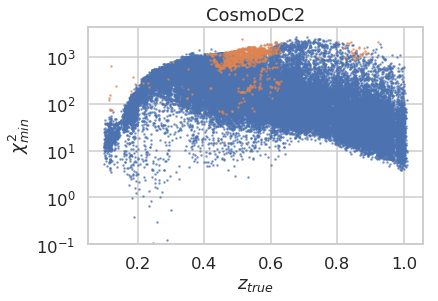

In [149]:
plt.scatter(gal['z_true'][good],d3_good,s=1,alpha=0.7)
plt.scatter(gal['z_true'][bad],d3_bad,s=1,alpha=0.7)
plt.yscale('log')
plt.ylim(1e-1,)
plt.ylabel(r'$\chi^2_{min}$',fontsize=18)
plt.xlabel(r'$z_{true}$')
plt.title('CosmoDC2')

In [63]:
b3_err = np.sqrt(gal['gr_err']**2+gal['iz_err']**2+gal['ri_err']**2)

Text(0,0.5,'$c_3/\\sigma_3$')

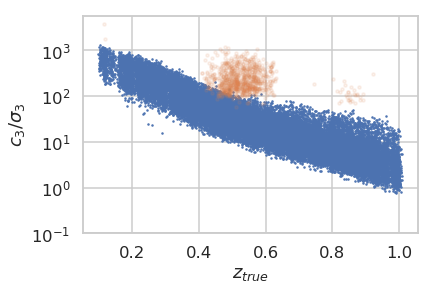

In [64]:
plt.scatter(gal['z_true'][good],np.sqrt(d3_good)/b3_err[good],s=1)
plt.scatter(gal['z_true'][bad],np.sqrt(d3_bad)/b3_err[bad],s=10,alpha=0.1)
plt.yscale('log')
plt.ylim(1e-1,)
plt.xlabel('$z_{true}$')
plt.ylabel(r'$c_3/\sigma_3$')

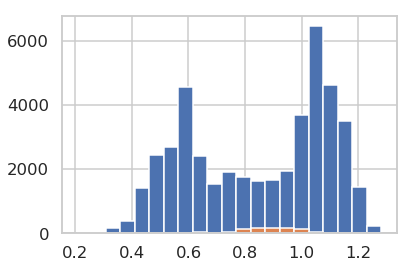

In [185]:
a = plt.hist(gr,bins=21)
_ = plt.hist(gr[kmask],bins=a[1])

In [50]:
gal.colnames[36:]

['mass_weight_age_err',
 'gi_o',
 'index',
 'rabs',
 'gr_o_err',
 'gi_o_err',
 'kri',
 'zmet',
 'best_chisq',
 'mass_err',
 'kii_err',
 'kri_err',
 'ssfr_std',
 'kii',
 'best_model',
 'distmod',
 'best_zmet',
 'mcMass',
 'iobs',
 'taMass',
 'mass_weight_age',
 'iabs',
 'mass',
 'gr_o',
 'ssfr',
 'field',
 'jid',
 'Mag_true_g_lsst_z0',
 'Mag_true_i_lsst_z0',
 'Mag_true_r_sdss_z0',
 'mag_r_sdss',
 'mag_i_sdss',
 'baseDC2/is_on_red_sequence_ri',
 'photoz_mask',
 'galaxy_id',
 'mag_true_i_lsst',
 'mag_true_i_sdss',
 'ra',
 'mag_true_g_lsst',
 'is_central',
 'mag_true_r_lsst',
 'baseDC2/is_on_red_sequence_gr',
 'dec',
 'mag_true_r_sdss',
 'Mag_true_i_sdss_z0',
 'Mag_true_r_lsst_z0',
 'GID_2',
 'ran',
 'decn']

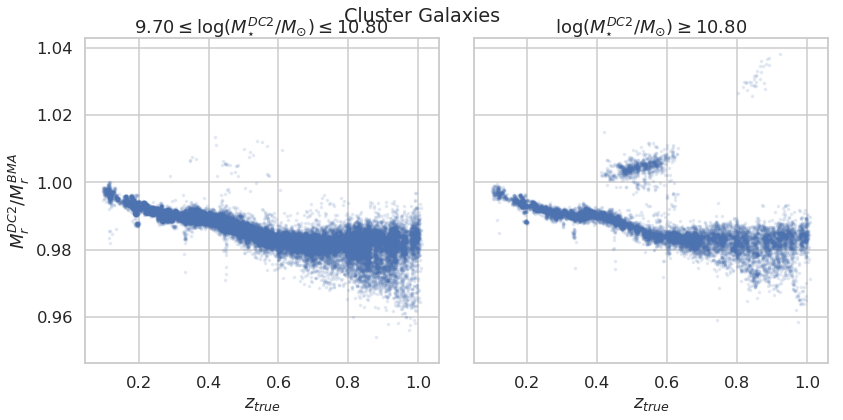

In [40]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask1],'Mr',ax=axis[0],title=r'$ %.2f \leq \log (M_{\star}^{DC2}/M_{\odot}) \leq %.2f$ '%(np.log10(ml),np.log10(mh)))
residual_evolution(gal[mask2],'Mr',ax=axis[1],title=r'$ \log (M_{\star}^{DC2}/M_{\odot}) \geq %.2f$'%np.log10(mh))
fig.suptitle('Cluster Galaxies')
axis[0].set_ylabel(residual_labels[1])
fig.tight_layout()
plt.savefig('../graphs/residual_Mr_evolution.png')
# axis[0].set_ylim(1,-1.)

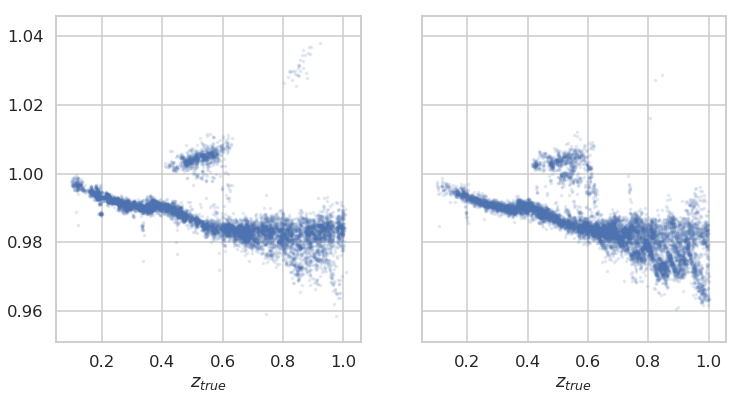

In [41]:
ml,mh = 10**10.9, 10**14
maska = (gal['stellar_mass']>=ml)&(gal['stellar_mass']<=mh)
maskb = (galb['stellar_mass']>=ml)&(galb['stellar_mass']<=mh)

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[maska],'Mr',ax=axis[0])
residual_evolution(galb[maskb],'Mr',ax=axis[1])
# axis[0].set_ylim(1,-1.)

###  Select the second population

In this lines we will classify the distribution in two populations: A and B

In [42]:
def get_labels(data):
    z,residual,mass = get_residual_variables(data,'Mr')
    mask = (residual > 1.)&(z>0.4)&(z<0.7)
    return mask

In [43]:
pop = get_labels(gal)
npop= np.logical_not(pop)

In [44]:
popb = get_labels(galb)
npopb= np.logical_not(popb)

In [45]:
mh = 10**(10.8)
mask2 = (gal['stellar_mass']>=mh)
mask2b= (galb['stellar_mass']>=mh)

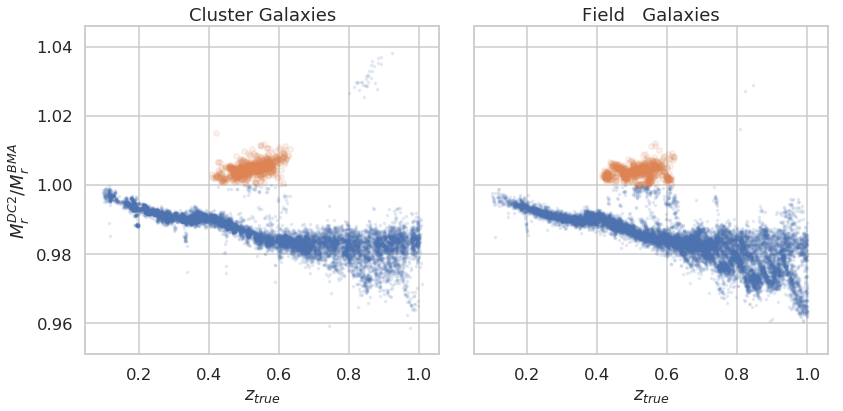

In [46]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask2&(npop)],'Mr',ax=axis[0])
residual_evolution(gal[mask2&(pop )],'Mr',s=30,ax=axis[0],title='Cluster Galaxies')

residual_evolution(galb[mask2b&(npopb)],'Mr',ax=axis[1])
residual_evolution(galb[mask2b&(popb)],'Mr',s=30,ax=axis[1],title='Field   Galaxies')
axis[0].set_ylabel(residual_labels[1])
fig.tight_layout()

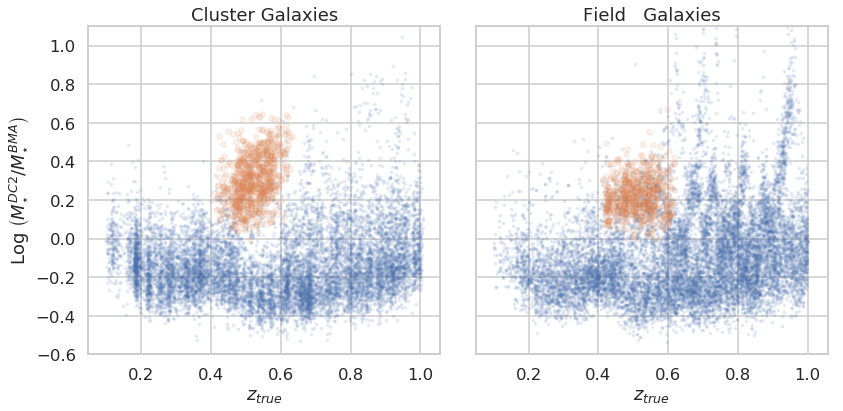

In [52]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')
residual_evolution(gal[mask2&(npop)],'mass',ax=axis[0])
residual_evolution(gal[mask2&(pop )],'mass',s=30,ax=axis[0],title='Cluster Galaxies')

residual_evolution(galb[mask2b&(npopb)],'mass',ax=axis[1])
residual_evolution(galb[mask2b&(popb)],'mass',s=30,ax=axis[1],title='Field   Galaxies')
axis[0].set_ylim(-0.6,1.1)
axis[0].set_ylabel(residual_labels[0])
fig.tight_layout()

In [48]:
### plot color

### Looking for Correlations

On color, radial, 

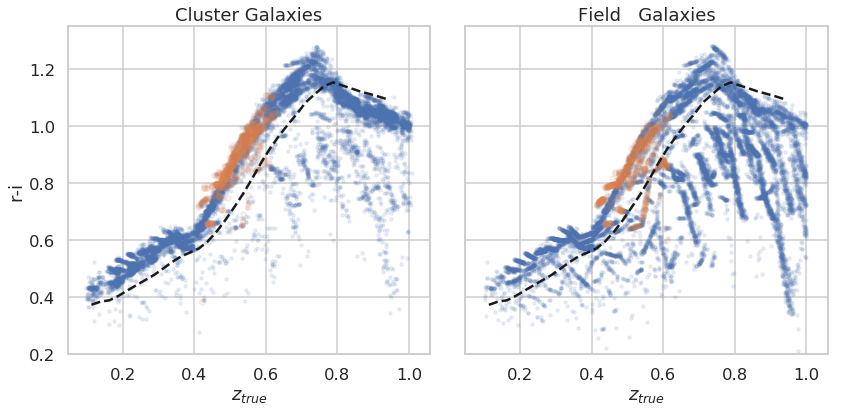

In [69]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask2&(npop)],'r-i',ax=axis[0])
color_evolution(gal[mask2&(pop )],'r-i',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,4],'k--')


color_evolution(galb[mask2b&(npopb)],'r-i',ax=axis[1])
color_evolution(galb[mask2b&(popb)],'r-i',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,4],'k--',label='DES Y3 red sequence')
axis[0].set_ylabel('r-i')
axis[0].set_ylim(0.2,1.35)
fig.tight_layout()

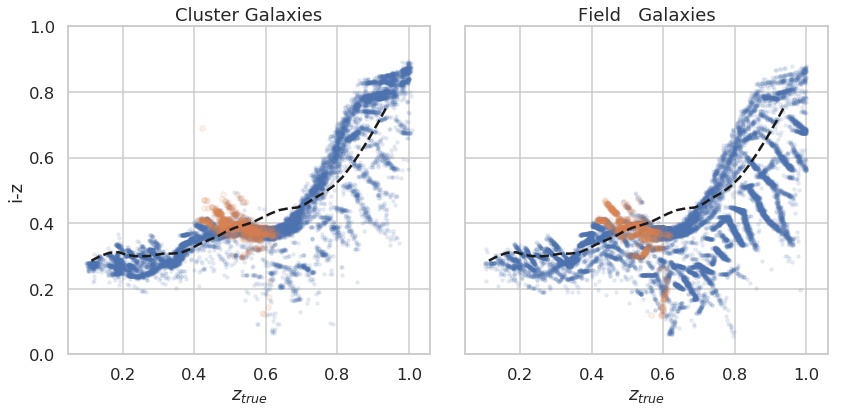

In [163]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex='all',sharey='all')

color_evolution(gal[mask2&(npop)],'i-z',ax=axis[0])
color_evolution(gal[mask2&(pop )],'i-z',s=30,ax=axis[0],title='Cluster Galaxies')
axis[0].plot(rs[:,0],rs[:,7],'k--')

color_evolution(galb[mask2b&(npopb)],'i-z',ax=axis[1])
color_evolution(galb[mask2b&(popb)],'i-z',s=30,ax=axis[1],title='Field   Galaxies')
axis[1].plot(rs[:,0],rs[:,7],'k--')

axis[1].set_ylim(0.,1.)
axis[0].set_ylabel('i-z')
fig.tight_layout()

In [75]:
zbins = np.linspace(0.4,0.63,11)

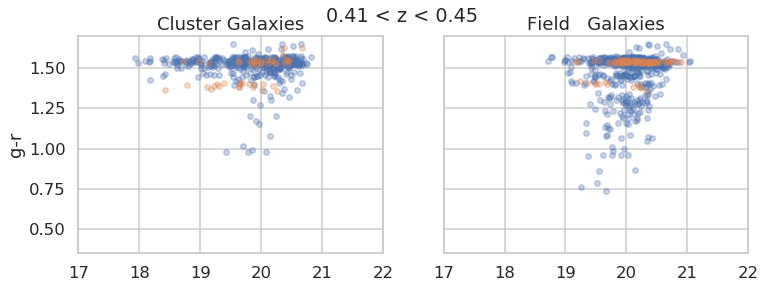

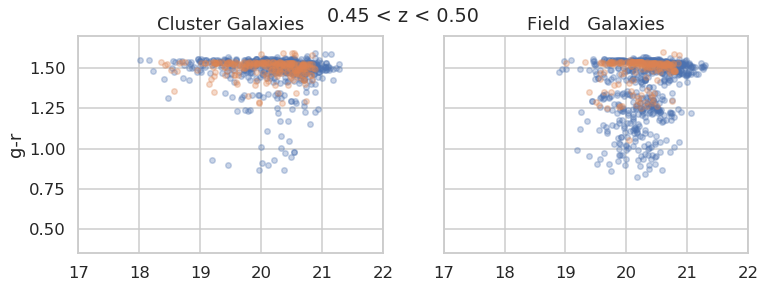

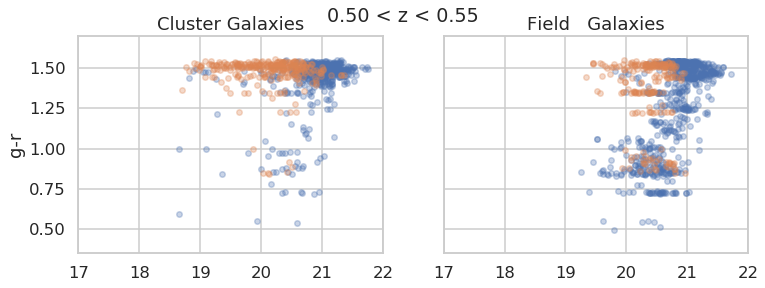

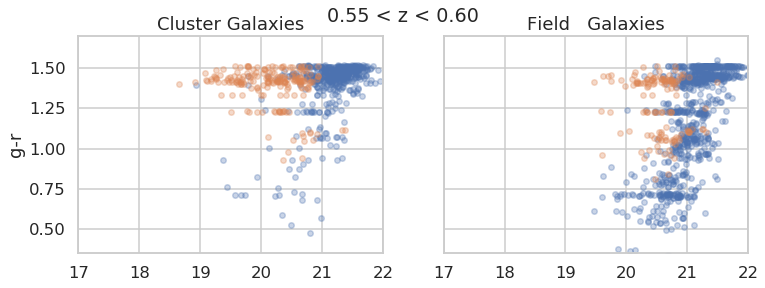

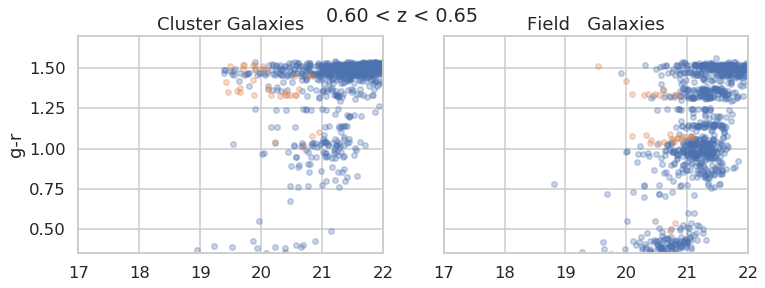

In [71]:
for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex='all',sharey='all')

    color_mag(gal[mask2&(npop)],'g-r',ax=axis[0],zlims=[zl,zh])
    color_mag(gal[mask2&(pop )],'g-r',s=30,ax=axis[0],title='Cluster Galaxies',zlims=[zl,zh])

    color_mag(galb[mask2b&(npopb)],'g-r',ix=1,ax=axis[1],zlims=[zl,zh])
    color_mag(galb[mask2b&(popb)],'g-r',ix=1,s=30,ax=axis[1],title='Field   Galaxies',zlims=[zl,zh])
    axis[0].set_ylabel('g-r')
    axis[0].set_xlim(17,22)
    axis[0].set_ylim(0.35,1.7)
    
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))

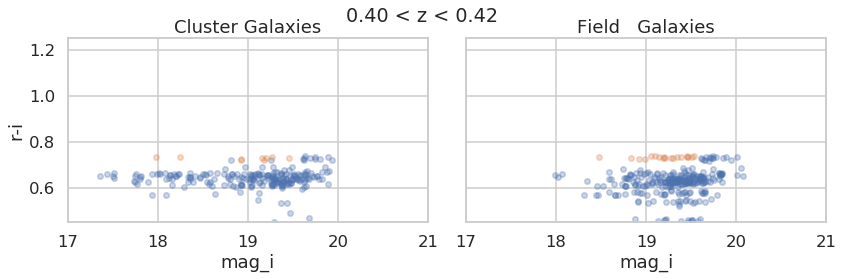

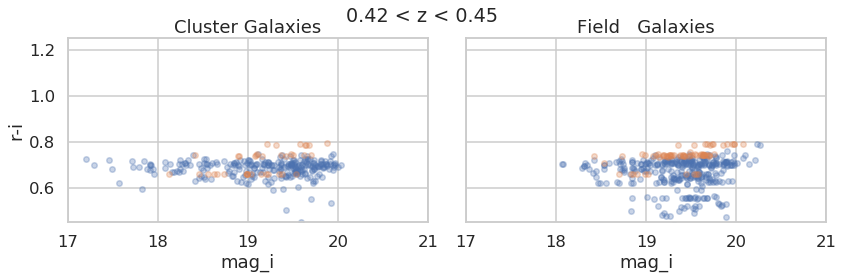

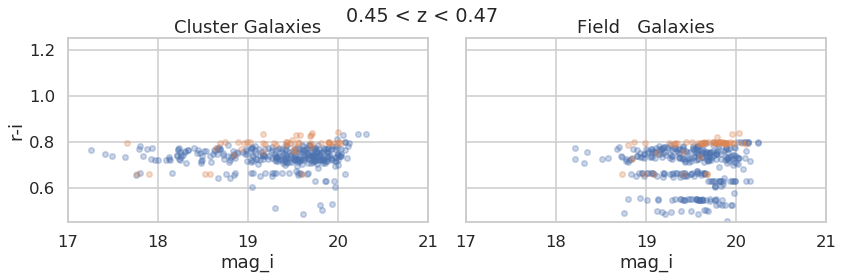

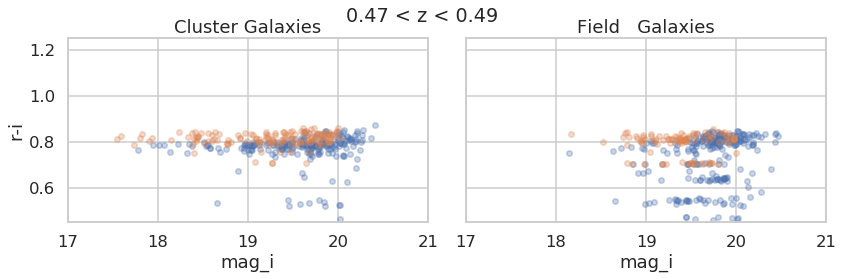

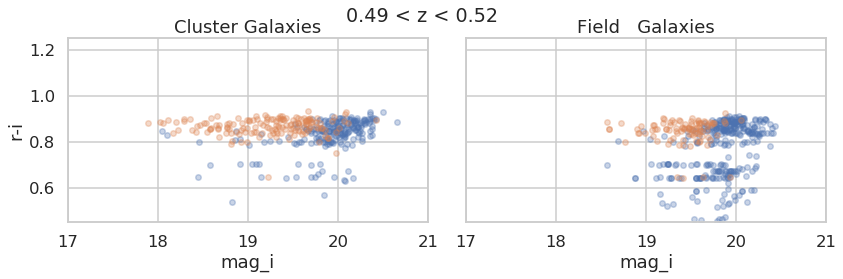

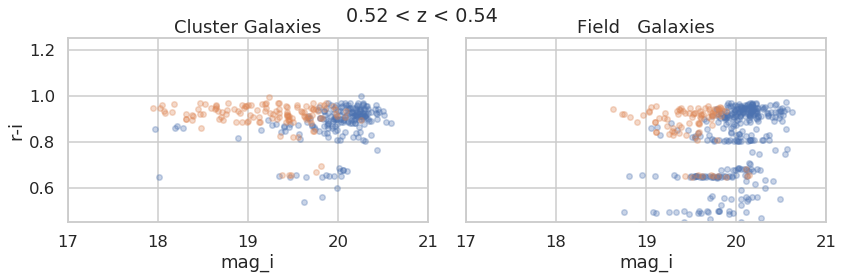

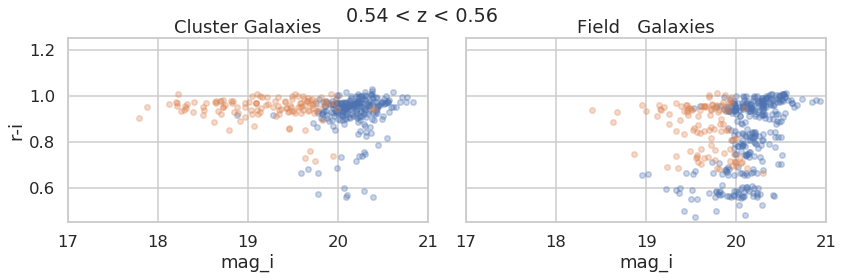

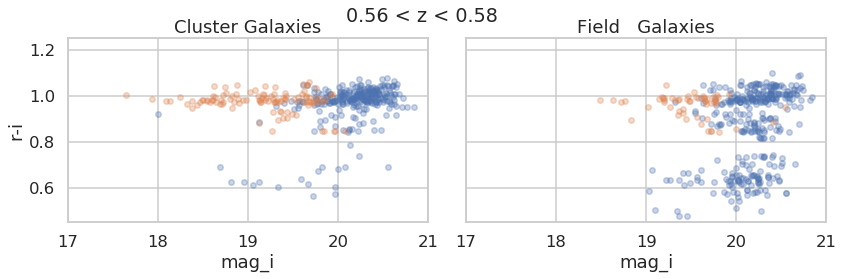

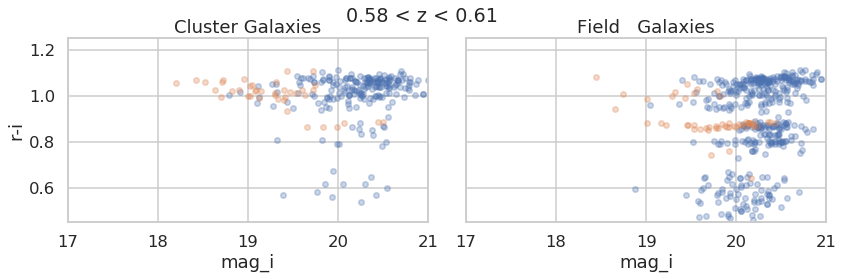

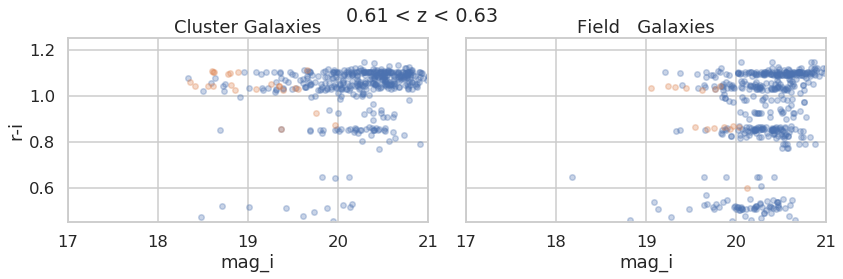

In [77]:
for i in range(len(zbins)-1):
    zl,zh = zbins[i],zbins[i+1]
    fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex='all',sharey='all')

    color_mag(gal[mask2&(npop)],'r-i',ix=2,ax=axis[0],zlims=[zl,zh])
    color_mag(gal[mask2&(pop )],'r-i',ix=2,s=30,ax=axis[0],title='Cluster Galaxies',zlims=[zl,zh])

    color_mag(galb[mask2b&(npopb)],'r-i',ix=2,ax=axis[1],zlims=[zl,zh])
    color_mag(galb[mask2b&(popb)],'r-i',ix=2,s=30,ax=axis[1],title='Field   Galaxies',zlims=[zl,zh])
    axis[0].set_ylabel('r-i')
    axis[0].set_xlabel('mag_i')
    axis[1].set_xlabel('mag_i')
    axis[0].set_xlim(17,21)
    axis[0].set_ylim(0.45,1.25)
    
    fig.suptitle('%.2f < z < %.2f'%(zl,zh))
    fig.tight_layout()
    plt.savefig('../graphs/gif/color_mag_ri_{:02d}.png'.format(i))

#### Spatial Distribution

In [78]:
radii = gal['R']*0.7
radiib= galb['R']*0.7

Text(0.5,0,'R [Mpc]')

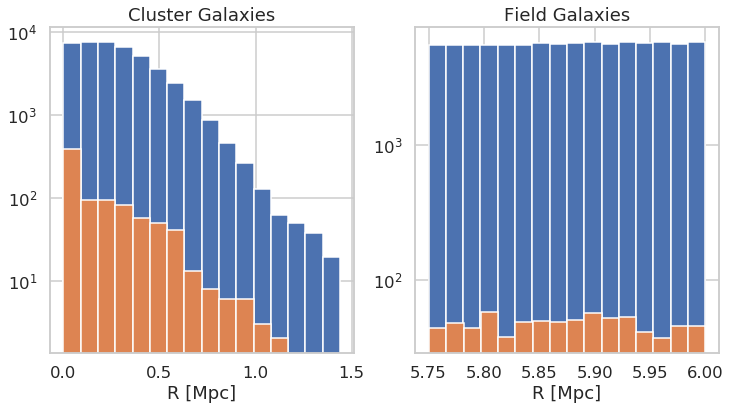

In [97]:
fig, axis = plt.subplots(1, 2, figsize=(12,6))

a = axis[0].hist(radii[npop],bins=16,density=False)
axis[0].hist(radii[pop],bins=a[1],density=False)
axis[0].set_yscale('log')
axis[0].set_title('Cluster Galaxies')
axis[0].set_xlabel('R [Mpc]')

axis[1].hist(radiib[npopb],bins=16,density=False)
axis[1].hist(radiib[popb] ,bins=16,density=False)
axis[1].set_yscale('log')
axis[1].set_title('Field Galaxies')
axis[1].set_xlabel('R [Mpc]')

In [81]:
1.*np.count_nonzero(radii[pop]<0.1)/np.count_nonzero(pop)

0.4710059171597633

In [90]:
ra, dec = gal['RA'],gal['DEC']
rab,decb= galb['RA'],galb['DEC']

Text(0,0.5,'DEC')

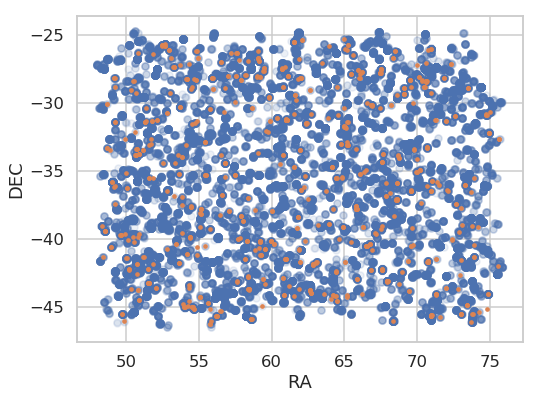

In [96]:
plt.figure(figsize=(8,6))
plt.scatter(ra[npop],dec[npop],s=50,alpha=0.1)
plt.scatter(ra[pop],dec[pop],s=10)

plt.xlabel('RA')
plt.ylabel('DEC')

### Looking for Correlations with Halos

In [99]:
def compute_nbad(keys):
    res = np.array([idx.size for idx in keys])
    return res

def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [140]:
zcls = cat['redshift']
w = (zcls>0.45)&(zcls<0.6)

In [146]:
cids  = cat['CID']
keys = list(chunks(gal['CID'][mask2&pop],cids))
keys2= list(chunks(gal['CID'][mask2],cids))

In [159]:
nbad = compute_nbad(keys)
ngals= compute_nbad(keys2)
fraction = 1.*nbad/ngals

In [148]:
ntrue = cat['Ngals_true']
m200  = cat['M200_true']

Text(0.5,0,'$f_{pop}$ per halo')

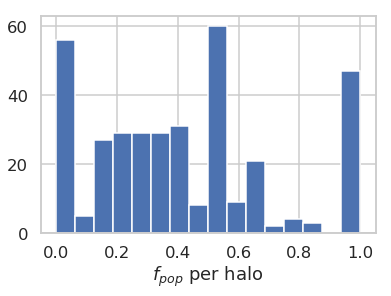

In [155]:
plt.hist(1.*nbad[w]/ngals[w],bins=16)
plt.xlabel(r'$f_{pop}$ per halo')
# plt.yscale('log')

Text(0,0.5,'$N_{pop}$')

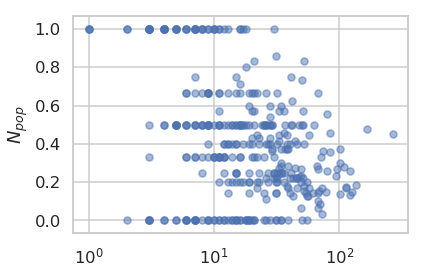

In [162]:
plt.scatter(ntrue[w],fraction[w],alpha=0.5,s=50)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0.5,)
plt.ylabel(r'$N_{pop}$')
# plt.xlabel('halo_mass')

In [182]:
ra,dec = cat['RA'],cat['DEC']

In [179]:
mask = (nbad==0)&(np.abs(cat['redshift']-0.50)<=0.10)

In [180]:
def plot_sky(ra,dec):
    plt.scatter(ra,dec)


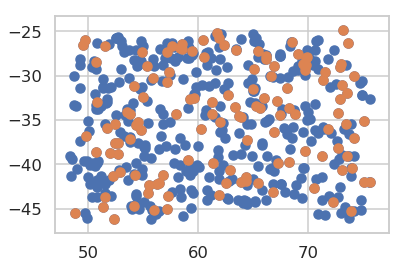

In [183]:
plot_sky(ra[w],dec[w])
plot_sky(ra[mask],dec[mask])

In [ ]:
def makeBins(variable,xedges):
    nsize=len(xedges)-1
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable < xedges[i + 1]))[0] for i in range(nsize)]
    return indices, xbins


In [413]:
def mass_scatter_residual(x1,x2,x3,zlabel='$z_{cls}$'):
    cut = remove_nan(x2)
    x = np.log10(x2[cut]/x1[cut])
    
    idx = np.flip(np.argsort(x3))
    plt.scatter(np.log10(x1)[idx],x[idx],c=x3[idx],cmap='RdBu',s=5,alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label(zlabel)

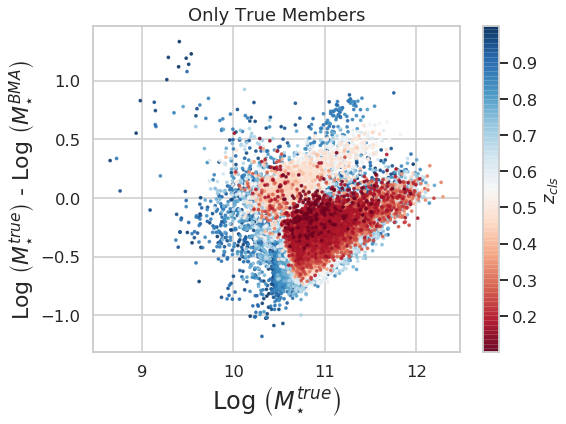

In [414]:
plt.figure(figsize=(8,6))
mass_scatter_residual(mass[mask],mass_t[mask],zcls[mask])
plt.ylabel(r'Log $\left(M_{\star}^{true} \right)$ - Log $\left( M_{\star}^{BMA} \right)$',fontsize=22)
plt.xlabel(r'Log $\left(M_{\star}^{true} \right)$',fontsize=24)

# plt.xlim(9.5,12.5)
# plt.ylim(-1.5,1.5)
plt.title('Only True Members')
plt.tight_layout()
plt.savefig('stellar_mass_residual_mtrue.png')

In [20]:
magi = gal['mag'][:,3]
amag = gal['rabs']
pmem = gal['Pmem']

In [40]:
def get_percentile_curve(x,y,q=95,nbins=12):
    xedges = np.linspace(0.98*np.min(x),1.02*np.max(x),nbins)
    keys, xmean = makeBins(x,xedges)
    ypercentile = [np.percentile(y[idx],q) for idx in keys]
    return xmean, ypercentile
    
def plot_redshift_variable(x,y,q=95,ax=None,weights=None):
    if ax is None: ax = plt.axes()
    cut = remove_nan(y)
    x, y = x[cut], y[cut]
    
    if weights is not None: weights = weights[cut]
        
    xb, yp = get_percentile_curve(x,y,q=q,nbins=31)
    
    ax.hexbin(x,y,gridsize=(25,25),cmap='Reds',C=weights,reduce_C_function=np.sum)
    ax.plot(xb,yp,'k--',label='%ith percentile'%(q))
    ax.set_xlabel(r'$z_{cls}$',fontsize=24)
    ax.legend()

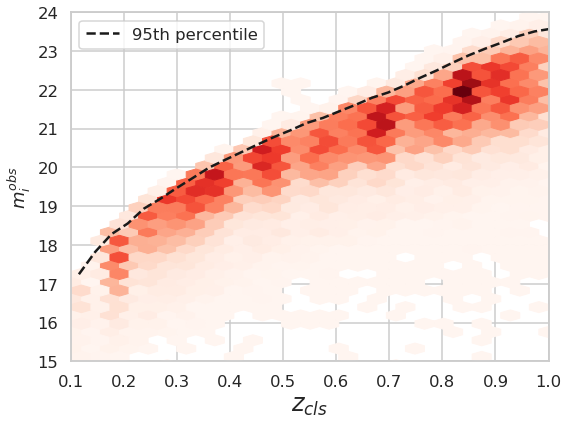

In [22]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,magi,weights=pmem)
plt.xlim(0.1,1.0)
plt.ylim(15,24)
plt.ylabel('$m_{i}^{obs}$')
plt.tight_layout()
plt.savefig('mag_obs_cut.png')

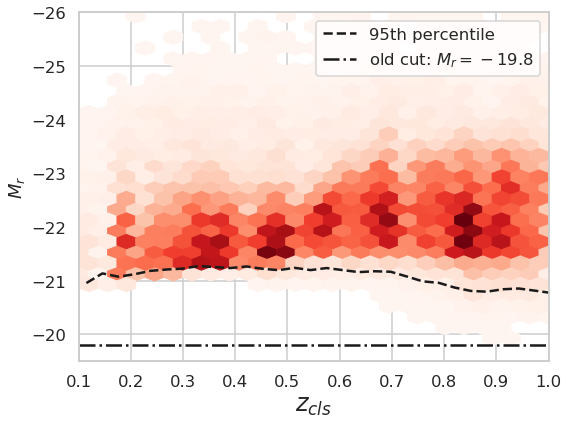

In [23]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,amag,weights=pmem)
plt.axhline(-19.8,color='k',linestyle='-.',label='old cut: $M_{r}=-19.8$')
plt.xlim(0.1,1.0)
plt.ylim(-19.5,-26)
plt.legend()
plt.ylabel('$M_{r}$')
plt.tight_layout()
plt.savefig('amag_cut.png')

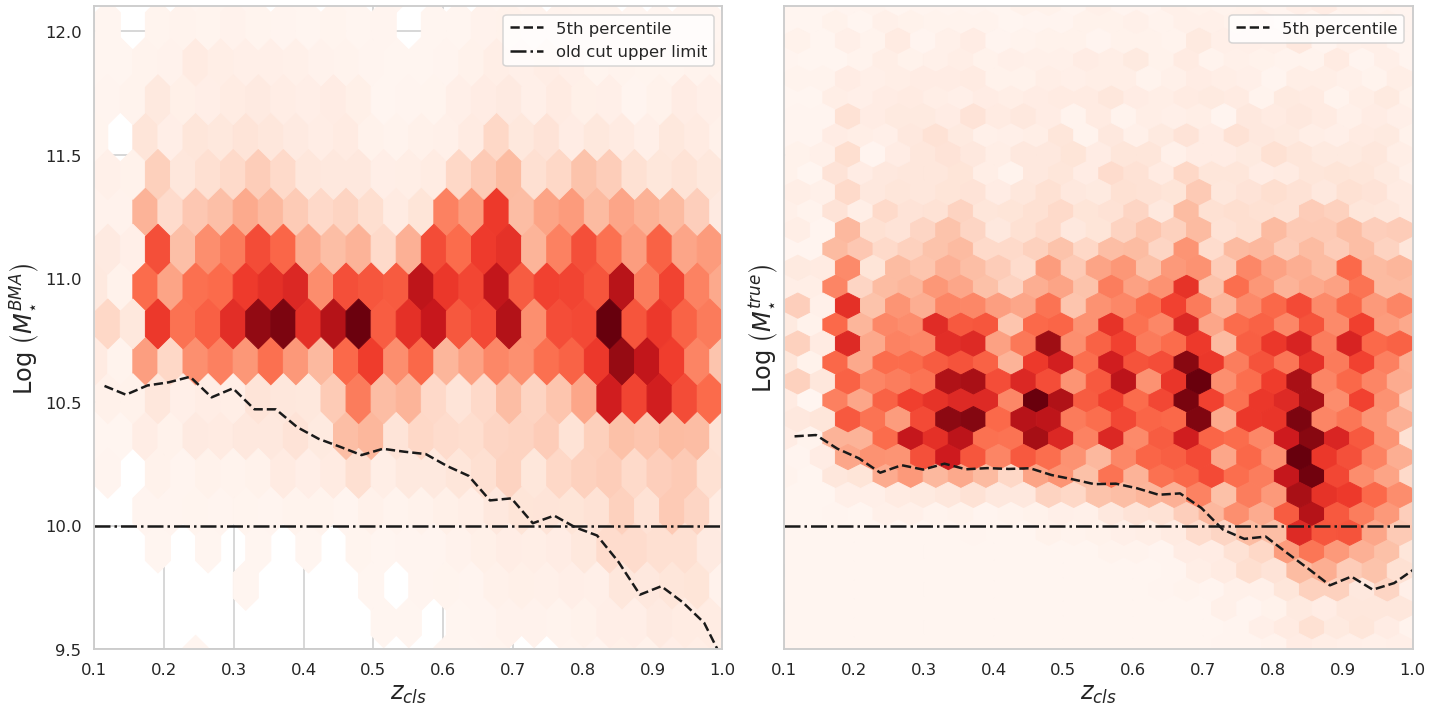

In [24]:
fig, ax = plt.subplots(1,2, sharey='row', sharex='row', figsize=(20,10))
fig.subplots_adjust(wspace=0.15)

plot_redshift_variable(zcls[bads],np.log10(mass[bads]),weights=pmem[bads],q=5,ax=ax[0])
plot_redshift_variable(zcls[mask],np.log10(mass_t[mask]),q=5, ax=ax[1])

ax[0].set_ylabel(r'Log $\left( M_{\star}^{BMA} \right)$',fontsize=24)
ax[1].set_ylabel(r'Log $\left( M_{\star}^{true} \right)$',fontsize=24)

ax[0].set_ylim(9.5,12.1)
ax[0].set_xlim(0.1,1.)

for i in range(2):
    ax[i].axhline(10,color='k',linestyle='-.',label='old cut upper limit')

ax[0].legend()
plt.tight_layout()

plt.savefig('stellar_mass_cut.png')